***

In [1]:
import cv2
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
import tensorflow as tf

In [5]:
data_path=(r"C:\Users\KIIT\Desktop\AI ML\project\dataset")
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels))
print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [6]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)

Exception: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



In [7]:
import numpy as np
import keras
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [8]:
data.shape

(1376, 100, 100, 1)

In [9]:
new_target.shape

(1376, 2)

In [10]:
np.save('data',data)
np.save('target',new_target)

In [11]:
 from tensorflow.keras.models import Sequential

In [12]:

from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
a=data.shape[1:]
a

(100, 100, 1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(data,new_target,test_size=0.2)

In [15]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(X_train,Y_train,epochs=10,batch_size=32,callbacks=[checkpoint],validation_split=0.2)

Train on 880 samples, validate on 220 samples
Epoch 1/10
864/880 [============================>.] - ETA: 0s - loss: 0.7843 - accuracy: 0.5417WARNING:tensorflow:From C:\Users\KIIT\.conda\envs\tfdl\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-001.model\assets
880/880 [==============================] - 43s 49ms/sample - loss: 0.7822 - accuracy: 0.5466 - val_loss: 0.6950 - val_accuracy: 0.4636
Epoch 2/10
880/880 [==============================] - 40s 46ms/sample - loss: 0.6826 - accuracy: 0.5386 - val_loss: 0.6613 - val_accuracy: 0.5727
Epoch 3/10
880/880 [==============================] - 40s 45ms/sample - loss: 0.5799 - accuracy: 0.6989 - val_loss: 0.7516 - val_accuracy: 0.5273
Ep

In [16]:
from sklearn.metrics import classification_report
predIdxs = model.predict(X_test)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('model.h5')

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       139
           1       0.89      0.96      0.92       137

    accuracy                           0.92       276
   macro avg       0.92      0.92      0.92       276
weighted avg       0.92      0.92      0.92       276

[INFO] saving mask detector model...


In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[122  17]
 [  6 131]]
acc: 0.9167
sensitivity: 0.8777
specificity: 0.9562


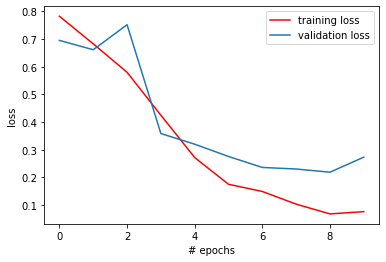

In [18]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

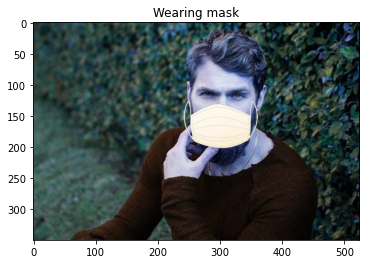

In [19]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
pathtest=(r"C:\Users\KIIT\Desktop\AI ML\project\dataset\with mask\0-with-mask.jpg")
img_size=100
img=cv2.imread(pathtest)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized=cv2.resize(gray,(img_size,img_size))
data=[]
data.append(resized)
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
results=model.predict(data)
#model_out=model.predict([test_data])
if np.argmax(results) == 1 : str_label ='Not wearing mask'
else: str_label = 'Wearing mask'

plt.imshow(img,cmap='gray')
plt.title(str_label)

plt.imshow(img)

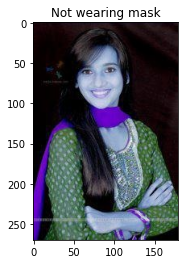

In [20]:
pathtest=(r"C:\Users\KIIT\Desktop\AI ML\project\dataset\without mask\0.jpg")
img_size=100
img=cv2.imread(pathtest)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized=cv2.resize(gray,(img_size,img_size))
data=[]
data.append(resized)
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
results=model.predict(data)
#model_out=model.predict([test_data])
if np.argmax(results) == 1 : str_label ='Not wearing mask'
else: str_label = 'Wearing mask'

plt.imshow(img,cmap='gray')
plt.title(str_label)

plt.imshow(img)

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import math
import time

In [22]:
face_clsfr=cv2.CascadeClassifier(r"C:\Users\KIIT\Desktop\AI ML\project\haar-cascade-files-master\haarcascade_frontalface_default.xml")
source=cv2.VideoCapture(0)
labels_dict={0:'wearing mask',1:'not wearing mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
while(True):

    ret,im=source.read()
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5,0)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',im)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()


***

***